In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
 
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime')
 
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.4.1
Running on TPU  ['10.77.147.130:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.77.147.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.77.147.130:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


##Sentiment Analysis for Depression Detection on Twitter

In [3]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from math import log, sqrt, exp
import pandas as pd
import numpy as np
from numpy import sign

import re
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

from keras import optimizers
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
depressed_tweets = pd.read_csv('/content/drive/MyDrive/BTP-SEM4/datasets/depressed_tweets.csv', nrows = 150000)
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "tweet"]
random_tweets = pd.read_csv('/content/drive/MyDrive/BTP-SEM4/datasets/nondepressive/training.1600000.processed.noemoticon.csv', encoding = "ISO-8859-1", names = DATASET_COLUMNS)

In [ ]:
depressed_tweets.head()

,Unnamed: 0,tweet,vader_score,vader_sentiment_label
0,0,"Wow, my dad yday: “you don’t take those stupid...",-0.2699,0
1,1,what part of this was really harmfult of a lot...,-0.5995,0
2,3,see i wanna do one of them but they all say th...,-0.8643,0
3,4,IS IT clinical depression or is it the palpabl...,-0.8316,0
4,7,Hope it's working for you. I was on sertralin...,-0.3506,0


In [ ]:
random_tweets.head()

,target,ids,date,flag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
group = random_tweets.groupby(random_tweets.target)
random_tweets = group.get_group(4)
random_tweets = random_tweets[:150000]

random_tweets['label'] = [1]*150000
depressed_tweets['label'] = [0]*150000

In [6]:
random_tweets.drop(['target','ids','date','flag','user'], axis = 1, inplace = True)
depressed_tweets.drop(['Unnamed: 0','vader_score','vader_sentiment_label'], axis = 1, inplace = True)

df = pd.concat([random_tweets,depressed_tweets], ignore_index  =True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   tweet   300000 non-null  object
 1   label   300000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 4.6+ MB


**TOKENIZATION**

In order to get our computer to understand any text, we need to break that word down in a way that our machine can understand. That’s where the concept of tokenization in Natural Language Processing (NLP) comes in.Tokenization is a 
way of separating a piece of text into smaller units called tokens. Here, tokens can be either words, characters, or subwords. Hence, tokenization can be broadly classified into 3 types – word, character, and subword (n-gram characters) tokenization. Later on these tokens are assigned an unique number.

In [7]:
from nltk.tokenize import TweetTokenizer
tk = TweetTokenizer(reduce_len=True)

data = []

X = df['tweet'].tolist()
Y = df['label'].tolist()

for x, y in zip(X, Y):
    if y == 1:
        data.append((tk.tokenize(x), 1))
    else:
        data.append((tk.tokenize(x), 0))
      
data[:5]

[(['I', 'LOVE', '@Health4UandPets', 'u', 'guys', 'r', 'the', 'best', '!', '!'],
  1),
 (['im',
   'meeting',
   'up',
   'with',
   'one',
   'of',
   'my',
   'besties',
   'tonight',
   '!',
   'Cant',
   'wait',
   '!',
   '!',
   '-',
   'GIRL',
   'TALK',
   '!',
   '!'],
  1),
 (['@DaRealSunisaKim',
   'Thanks',
   'for',
   'the',
   'Twitter',
   'add',
   ',',
   'Sunisa',
   '!',
   'I',
   'got',
   'to',
   'meet',
   'you',
   'once',
   'at',
   'a',
   'HIN',
   'show',
   'here',
   'in',
   'the',
   'DC',
   'area',
   'and',
   'you',
   'were',
   'a',
   'sweetheart',
   '.'],
  1),
 (['Being',
   'sick',
   'can',
   'be',
   'really',
   'cheap',
   'when',
   'it',
   'hurts',
   'too',
   'much',
   'to',
   'eat',
   'real',
   'food',
   'Plus',
   ',',
   'your',
   'friends',
   'make',
   'you',
   'soup'],
  1),
 (['@LovesBrooklyn2', 'he', 'has', 'that', 'effect', 'on', 'everyone'], 1)]

In [8]:
import re, string


from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
STOP_WORDS = stopwords.words('english')

def cleaned(token):
    if token == 'u':
        return 'you'
    if token == 'r':
        return 'are'
    if token == 'some1':
        return 'someone'
    if token == 'yrs':
        return 'years'
    if token == 'hrs':
        return 'hours'
    if token == 'mins':
        return 'minutes'
    if token == 'secs':
        return 'seconds'
    if token == 'pls' or token == 'plz':
        return 'please'
    if token == '2morow' or token == '2moro':
        return 'tomorrow'
    if token == '2day':
        return 'today'
    if token == '4got' or token == '4gotten':
        return 'forget'
    if token in ['hahah', 'hahaha', 'hahahaha']:
        return 'haha'
    if token == "mother's":
        return "mother"
    if token == "mom's":
        return "mom"
    if token == "dad's":
        return "dad"
    if token == 'bday' or token == 'b-day':
        return 'birthday'
    if token in ["i'm", "don't", "can't", "couldn't", "aren't", "wouldn't", "isn't", "didn't", "hadn't","doesn't", "won't", "haven't", "wasn't", "hasn't", "shouldn't", "ain't", "they've"]:
        return token.replace("'", "")
    if token in ['lmao', 'lolz', 'rofl']:
        return 'lol'
    if token == '<3':
        return 'love'
    if token == 'thanx' or token == 'thnx' or token == "thnks":
        return 'thanks'
    if token == 'goood':
        return 'good'
    if token in ['amp', 'quot', 'lt', 'gt', '½25', '..', '. .', '. . .']:
        return ''
    return token



def remove_noise(tweet_tokens):

    cleaned_tokens = []

    for token in tweet_tokens:
        
        token = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", token)
        
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
        
        cleaned_token = cleaned(token.lower())
        
        if cleaned_token == "idk":
            cleaned_tokens.append('i')
            cleaned_tokens.append('dont')
            cleaned_tokens.append('know')
            continue
        if cleaned_token == "i'll":
            cleaned_tokens.append('i')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "you'll":
            cleaned_tokens.append('you')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "we'll":
            cleaned_tokens.append('we')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "it'll":
            cleaned_tokens.append('it')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "it's":
            cleaned_tokens.append('it')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "i've":
            cleaned_tokens.append('i')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "you've":
            cleaned_tokens.append('you')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "we've":
            cleaned_tokens.append('we')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "they've":
            cleaned_tokens.append('they')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "you're":
            cleaned_tokens.append('you')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "we're":
            cleaned_tokens.append('we')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "they're":
            cleaned_tokens.append('they')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "let's":
            cleaned_tokens.append('let')
            cleaned_tokens.append('us')
            continue
        if cleaned_token == "she's":
            cleaned_tokens.append('she')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "he's":
            cleaned_tokens.append('he')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "that's":
            cleaned_tokens.append('that')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "i'd":
            cleaned_tokens.append('i')
            cleaned_tokens.append('would')
            continue
        if cleaned_token == "you'd":
            cleaned_tokens.append('you')
            cleaned_tokens.append('would')
            continue
        if cleaned_token == "there's":
            cleaned_tokens.append('there')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "what's":
            cleaned_tokens.append('what')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "how's":
            cleaned_tokens.append('how')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "who's":
            cleaned_tokens.append('who')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "y'all" or cleaned_token == "ya'll":
            cleaned_tokens.append('you')
            cleaned_tokens.append('all')
            continue

        if cleaned_token.strip() and cleaned_token not in string.punctuation and len(cleaned_token)>2 and cleaned_token not in STOP_WORDS: 
            cleaned_tokens.append(cleaned_token)
            
    return cleaned_tokens
print(remove_noise(data[0][0]))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
['love', 'guys', 'best']


##Visualisation

In [ ]:
depressed_tweets_arr = [x for x in depressed_tweets['tweet']]
random_tweets_arr = [x for x in random_tweets['tweet']]
cleaned_depressed_tweets = remove_noise(depressed_tweets_arr)
cleaned_random_tweets = remove_noise(random_tweets_arr)

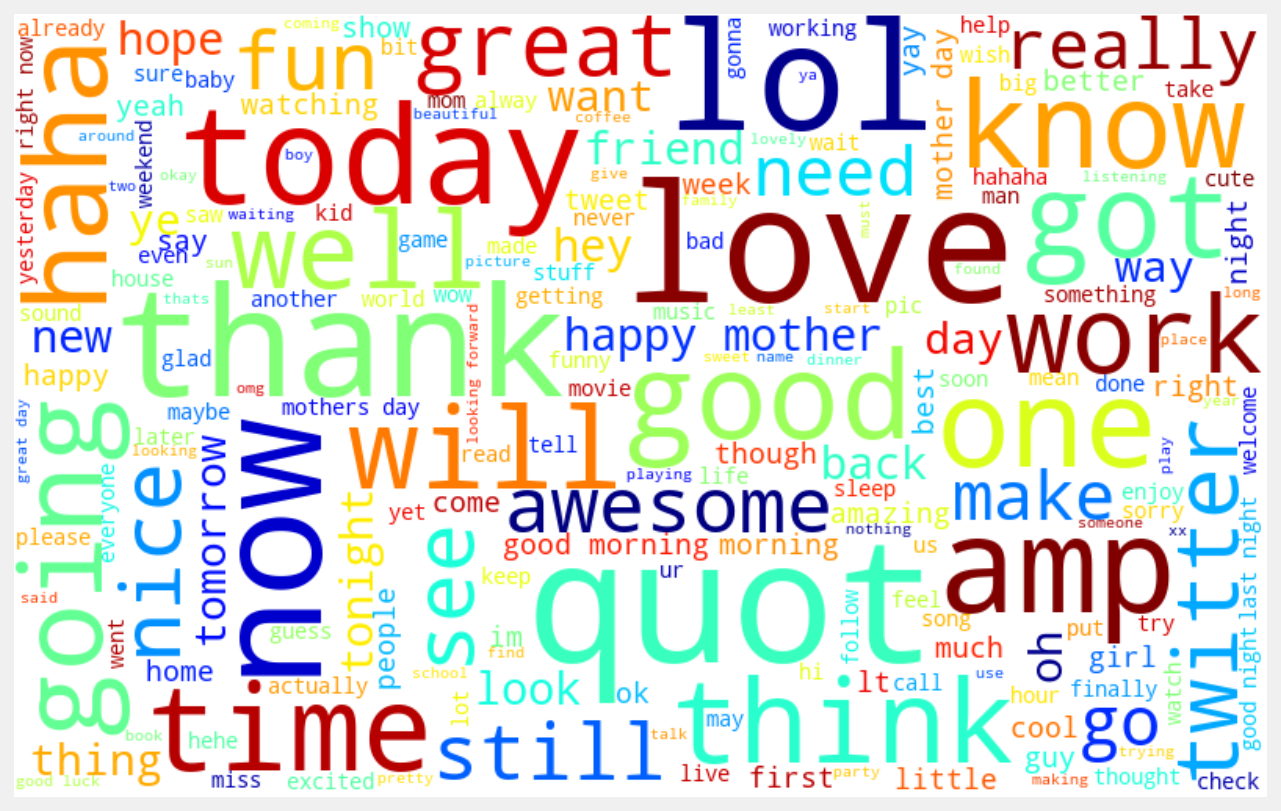

In [ ]:
#random tweets word cloud
all_words = ' '.join([text for text in cleaned_random_tweets])
from wordcloud import WordCloud
wordcloud = WordCloud(background_color = 'white', colormap = 'jet', width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


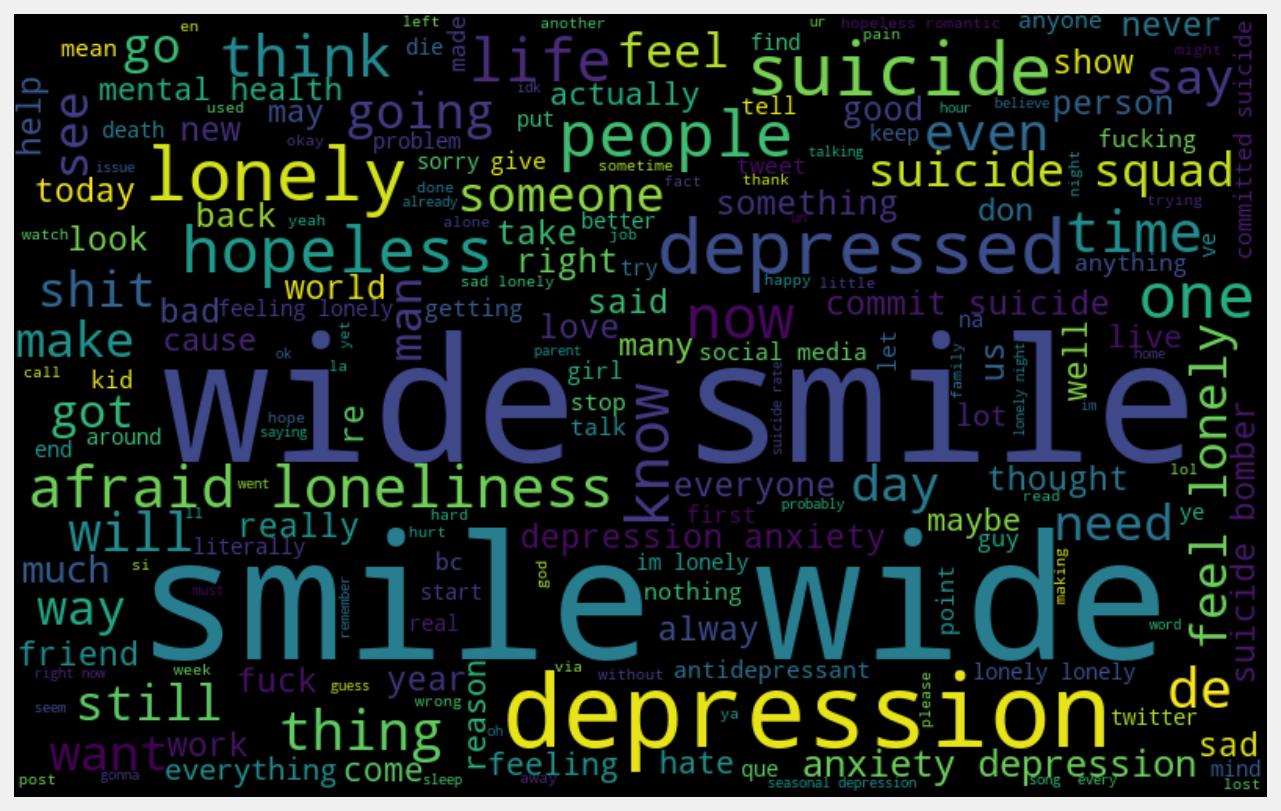

In [ ]:
#depressed tweets word cloud
all_words = ' '.join([text for text in cleaned_depressed_tweets])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**WORD EMBEDINGS**

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

Relationship between two words can be compared by the Euclidean distance (or cosine similarity) between two word vectors.
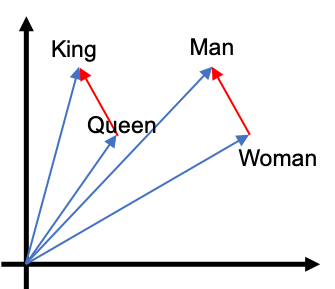

In [9]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [10]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/content/drive/MyDrive/BTP-SEM4/embeddings/glove.6B.300d.txt')
word_to_vec_map['hello']

array([-3.3712e-01, -2.1691e-01, -6.6365e-03, -4.1625e-01, -1.2555e+00,
       -2.8466e-02, -7.2195e-01, -5.2887e-01,  7.2085e-03,  3.1997e-01,
        2.9425e-02, -1.3236e-02,  4.3511e-01,  2.5716e-01,  3.8995e-01,
       -1.1968e-01,  1.5035e-01,  4.4762e-01,  2.8407e-01,  4.9339e-01,
        6.2826e-01,  2.2888e-01, -4.0385e-01,  2.7364e-02,  7.3679e-03,
        1.3995e-01,  2.3346e-01,  6.8122e-02,  4.8422e-01, -1.9578e-02,
       -5.4751e-01, -5.4983e-01, -3.4091e-02,  8.0017e-03, -4.3065e-01,
       -1.8969e-02, -8.5670e-02, -8.1123e-01, -2.1080e-01,  3.7784e-01,
       -3.5046e-01,  1.3684e-01, -5.5661e-01,  1.6835e-01, -2.2952e-01,
       -1.6184e-01,  6.7345e-01, -4.6597e-01, -3.1834e-02, -2.6037e-01,
       -1.7797e-01,  1.9436e-02,  1.0727e-01,  6.6534e-01, -3.4836e-01,
        4.7833e-02,  1.6440e-01,  1.4088e-01,  1.9204e-01, -3.5009e-01,
        2.6236e-01,  1.7626e-01, -3.1367e-01,  1.1709e-01,  2.0378e-01,
        6.1775e-01,  4.9075e-01, -7.5210e-02, -1.1815e-01,  1.86

In [12]:
unks = []
UNKS = []
 
def cleared(word):
    res = ""
    prev = None
    for char in word:
        if char == prev: continue
        prev = char
        res += char
    return res

def sentence_to_indices(sentence_words, word_to_index, max_len, i):
    global X, Y
    sentence_indices = []
    for j, w in enumerate(sentence_words):
        try:
            index = word_to_index[w]
        except:
            UNKS.append(w)
            w = cleared(w)
            try:
                index = word_to_index[w]
            except:
                index = word_to_index['unk']
                unks.append(w)
        X[i, j] = index

cleaned_tokens_list = []

for tokens, label in data:
    x = remove_noise(tokens)
    if x:
        cleaned_tokens_list.append((x, label))

list_len = [len(i) for i, j in cleaned_tokens_list]
max_len = max(list_len)
print('max_len:', max_len)

X = np.zeros((len(cleaned_tokens_list), max_len))
Y = np.zeros((len(cleaned_tokens_list), ))

for i, tk_lb in enumerate(cleaned_tokens_list):
    tokens, label = tk_lb
    sentence_to_indices(tokens, word_to_index, max_len, i)
    Y[i] = label
    
print(X[:5])
print(Y[:5])

max_len: 49
[[226278. 169754.  74390.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.]
 [239792. 269953. 372306. 361859.  91041. 382320. 161844. 352214.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.]
 [357161. 368306.  46173. 372306. 164934. 239785. 179025. 329974.  58999.
  349437.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.     

##Building the Model

In [13]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len):
    vocab_len = len(word_to_index) + 1
    emb_dim = word_to_vec_map["unk"].shape[0] 
    
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]
        
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False, input_shape=(max_len,))
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [15]:
def model():
  model_cnnlstm = Sequential()

  model_cnnlstm.add(pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len))

  model_cnnlstm.add(Conv1D(filters=32,
                           kernel_size=3,
                           padding='same',
                           strides = 1,
                           activation='relu'))
  
  model_cnnlstm.add(MaxPooling1D(pool_size=2))

  model_cnnlstm.add(Dropout(0.5))

  model_cnnlstm.add(LSTM(units = 300,
                         activation="tanh",
                         recurrent_activation="sigmoid",
                         use_bias=True))

  model_cnnlstm.add(Dropout(0.5))

  model_cnnlstm.add(Dense(units = 1, 
                          activation='sigmoid',
                          use_bias=True,
                          bias_initializer='zeros'))

  
  return model_cnnlstm

In [16]:
with tpu_strategy.scope():
  model = model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 49, 300)           120000300 
_________________________________________________________________
conv1d (Conv1D)              (None, 49, 32)            28832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 24, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 300)               399600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

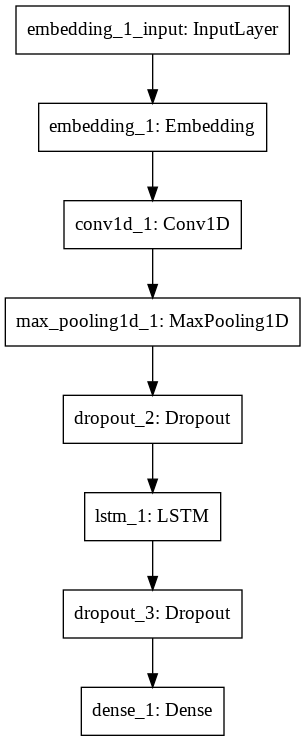

In [ ]:
tf.keras.utils.plot_model(model)

In [17]:
nadam = optimizers.Nadam(lr=0.0001,
                         beta_1=0.9,
                         beta_2=0.999,
                         epsilon=1e-8, 
                         schedule_decay=0.004)
model.compile(loss='binary_crossentropy',
              optimizer=nadam,
              metrics=['acc'])

In [18]:
early_stop = EarlyStopping(monitor='val_loss',
                           patience=3)
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs = 20,
                    batch_size = 128,
                    shuffle=True,
                    callbacks = [early_stop])


Epoch 1/20
1388/1388 [==============================] - 41s 26ms/step - loss: 0.2850 - acc: 0.8679 - val_loss: 0.1280 - val_acc: 0.9562
Epoch 2/20
1388/1388 [==============================] - 33s 24ms/step - loss: 0.1361 - acc: 0.9525 - val_loss: 0.1184 - val_acc: 0.9590
Epoch 3/20
1388/1388 [==============================] - 33s 24ms/step - loss: 0.1233 - acc: 0.9573 - val_loss: 0.1204 - val_acc: 0.9603
Epoch 4/20
1388/1388 [==============================] - 33s 24ms/step - loss: 0.1163 - acc: 0.9597 - val_loss: 0.1142 - val_acc: 0.9605
Epoch 5/20
1388/1388 [==============================] - 34s 24ms/step - loss: 0.1128 - acc: 0.9604 - val_loss: 0.1102 - val_acc: 0.9615
Epoch 6/20
1388/1388 [==============================] - 34s 24ms/step - loss: 0.1079 - acc: 0.9623 - val_loss: 0.1101 - val_acc: 0.9618
Epoch 7/20
1388/1388 [==============================] - 33s 24ms/step - loss: 0.1047 - acc: 0.9635 - val_loss: 0.1107 - val_acc: 0.9618
Epoch 8/20
1388/1388 [==========================

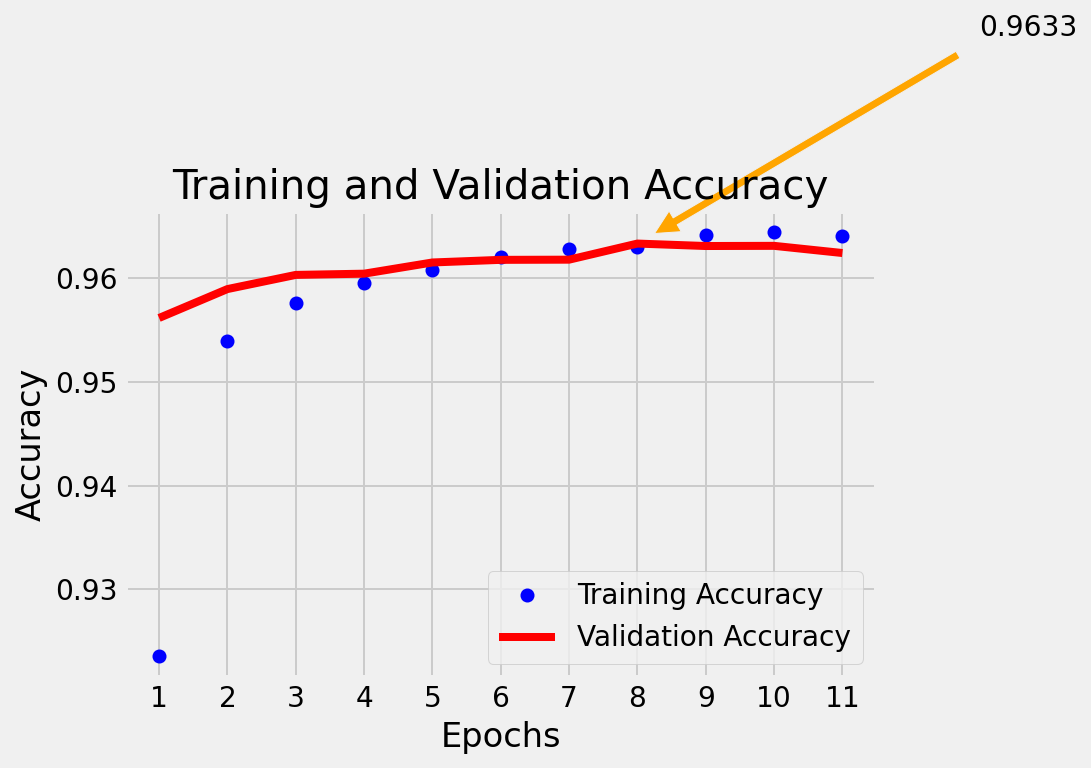

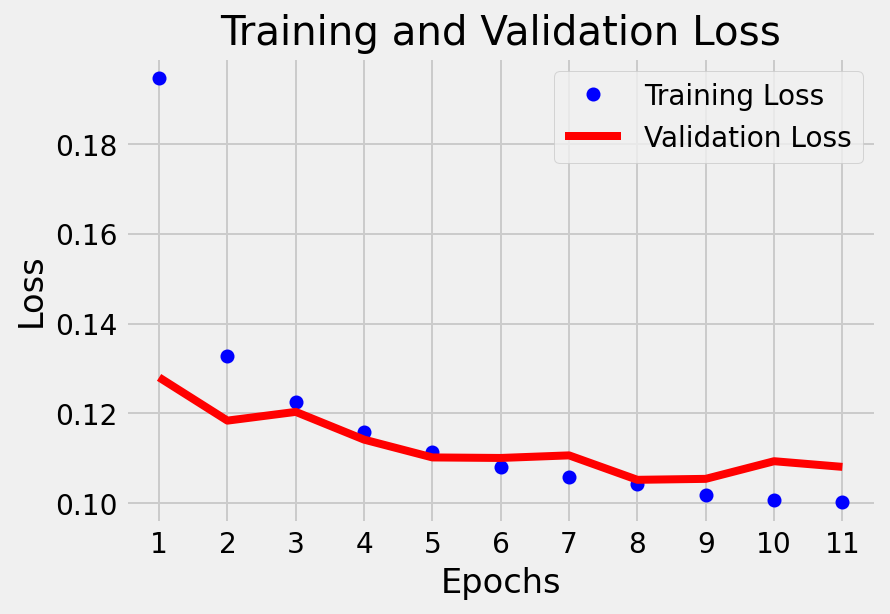

In [19]:
history = model.history

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
y_arrow = max(val_acc)
x_arrow = val_acc.index(y_arrow) + 1
plt.annotate(str(y_arrow)[:6],
             (x_arrow, y_arrow),
             xytext=(x_arrow + 5, y_arrow + .02),
             arrowprops=dict(facecolor='orange', shrink=0.05))
plt.xticks(epochs)

plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)
plt.show()

In [20]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred.flatten())

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.94      0.96     29314
         1.0       0.94      0.99      0.97     29877

    accuracy                           0.96     59191
   macro avg       0.97      0.96      0.96     59191
weighted avg       0.96      0.96      0.96     59191



In [22]:
score = model.evaluate(X_test, y_test)

1850/1850 [==============================] - 34s 18ms/step - loss: 0.1046 - acc: 0.9638


###Prediction on custom text

In [ ]:
def sentence_to_indices(sentence_words, max_len):
    X = np.zeros((max_len))
    sentence_indices = []
    for j, w in enumerate(sentence_words):
        try:
            index = word_to_index[w]
        except:
            w = cleared(w)
            try:
                index = word_to_index[w]
            except:
                index = word_to_index['unk']
        X[j] = index
    return X

def predict_tweet_sentiment(custom_tweet):
    
    x_input = sentence_to_indices(remove_noise(tk.tokenize(custom_tweet)), max_len)
    
   
    return model.predict(np.array([x_input])).item()

In [ ]:
predict_tweet_sentiment("I dont feel so good, i have depression")

0.0007512569427490234

In [ ]:
predict_tweet_sentiment("I feel really good")

0.9886043667793274

In [26]:
model.save('/content/drive/MyDrive/BTP-SEM4/model.h5')